<a href="https://colab.research.google.com/github/venom1204/symbolic/blob/main/task2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, Bidirectional, Attention, Concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
import json
import os
import time
from tqdm.notebook import tqdm
from sklearn.metrics import mean_squared_error
from google.colab import drive

In [2]:
# Mount Google Drive
drive.mount('/content/drive')
base_dir = '/content/drive/MyDrive/GSoC_Symbolic_Calculation'
model_data_dir = f'{base_dir}/model_data'

Mounted at /content/drive


In [4]:
print("Step 1: Loading data and setting up environment...")

# Mount Google Drive
drive.mount('/content/drive')
base_dir = '/content/drive/MyDrive/GSoC_Symbolic_Calculation'
model_data_dir = f'{base_dir}/model_data'
lstm_dir = f'{base_dir}/lstm_model'
os.makedirs(lstm_dir, exist_ok=True)

# Load data
train_df = pd.read_csv(f'{model_data_dir}/train_dataset.csv')
val_df = pd.read_csv(f'{model_data_dir}/val_dataset.csv')
test_df = pd.read_csv(f'{model_data_dir}/test_dataset.csv')

print(f"Loaded datasets - Train: {len(train_df)}, Validation: {len(val_df)}, Test: {len(test_df)} examples")

# Load token mappings
with open(f'{model_data_dir}/token_to_idx.json', 'r') as f:
    token_to_idx = json.load(f)

# Load padding information
with open(f'{model_data_dir}/padding_info.json', 'r') as f:
    padding_info = json.load(f)

# Create reverse mapping
idx_to_token = {int(idx): token for token, idx in token_to_idx.items()}

print(f"Vocabulary size: {len(token_to_idx)} tokens")
print(f"Padding lengths - Function: {padding_info['recommended_function_padding']}, Taylor: {padding_info['recommended_taylor_padding']}")

Step 1: Loading data and setting up environment...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loaded datasets - Train: 780, Validation: 167, Test: 168 examples
Vocabulary size: 510 tokens
Padding lengths - Function: 54, Taylor: 65



Step 2: Preprocessing data...
Converting tokens to sequences...
Padding sequences...


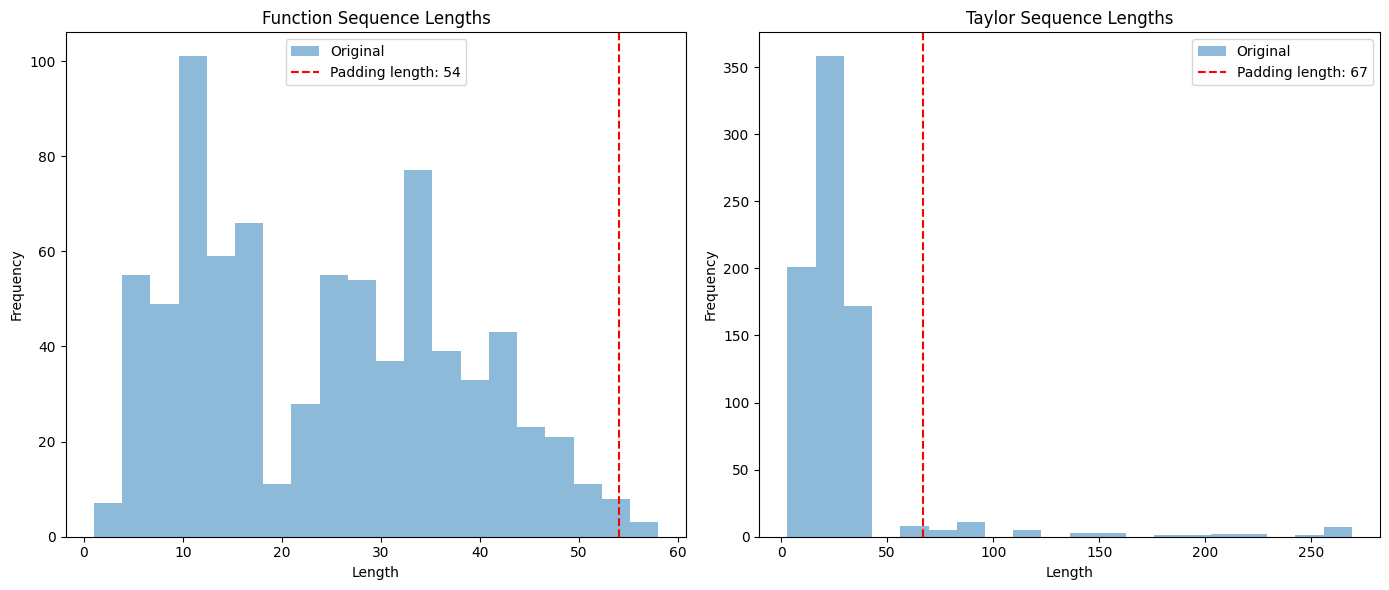

In [5]:
print("\nStep 2: Preprocessing data...")

# Convert string representation of lists to actual lists
def parse_tokens(token_str):
    if isinstance(token_str, str):
        # Remove brackets and split by comma
        tokens = token_str.strip('[]').replace("'", "").split(', ')
        return [t for t in tokens if t]
    return token_str

# Process the dataframes
for df in [train_df, val_df, test_df]:
    df['function_tokens'] = df['function_tokens'].apply(parse_tokens)
    df['taylor_tokens'] = df['taylor_tokens'].apply(parse_tokens)

# Convert tokens to sequences
def tokens_to_sequence(tokens):
    return [token_to_idx.get(token, token_to_idx.get('<OOV>', 1)) for token in tokens]

# Prepare input and target sequences
print("Converting tokens to sequences...")
X_train = [tokens_to_sequence(tokens) for tokens in train_df['function_tokens']]
y_train = [tokens_to_sequence(['<START>'] + tokens + ['<END>']) for tokens in train_df['taylor_tokens']]

X_val = [tokens_to_sequence(tokens) for tokens in val_df['function_tokens']]
y_val = [tokens_to_sequence(['<START>'] + tokens + ['<END>']) for tokens in val_df['taylor_tokens']]

X_test = [tokens_to_sequence(tokens) for tokens in test_df['function_tokens']]
y_test = [tokens_to_sequence(['<START>'] + tokens + ['<END>']) for tokens in test_df['taylor_tokens']]

# Pad sequences
max_input_len = padding_info['recommended_function_padding']
max_target_len = padding_info['recommended_taylor_padding'] + 2  # +2 for START and END tokens

print("Padding sequences...")
X_train_padded = pad_sequences(X_train, maxlen=max_input_len, padding='post')
y_train_padded = pad_sequences(y_train, maxlen=max_target_len, padding='post')

X_val_padded = pad_sequences(X_val, maxlen=max_input_len, padding='post')
y_val_padded = pad_sequences(y_val, maxlen=max_target_len, padding='post')

X_test_padded = pad_sequences(X_test, maxlen=max_input_len, padding='post')
y_test_padded = pad_sequences(y_test, maxlen=max_target_len, padding='post')

# Prepare teacher forcing data
decoder_input_train = y_train_padded[:, :-1]  # Remove last token
decoder_target_train = y_train_padded[:, 1:]  # Remove first token

decoder_input_val = y_val_padded[:, :-1]
decoder_target_val = y_val_padded[:, 1:]

# Visualize sequence lengths after padding
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.hist([len(seq) for seq in X_train], bins=20, alpha=0.5, label='Original')
plt.axvline(x=max_input_len, color='r', linestyle='--', label=f'Padding length: {max_input_len}')
plt.title('Function Sequence Lengths')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.legend()

plt.subplot(1, 2, 2)
plt.hist([len(seq) for seq in y_train], bins=20, alpha=0.5, label='Original')
plt.axvline(x=max_target_len, color='r', linestyle='--', label=f'Padding length: {max_target_len}')
plt.title('Taylor Sequence Lengths')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.savefig(f'{lstm_dir}/sequence_lengths.png')
plt.show()

In [10]:
print("\nStep 3: Building LSTM model with attention...")

# Build LSTM model with attention
vocab_size = len(token_to_idx)
embedding_dim = 256
lstm_units = 512

# Encoder
encoder_inputs = Input(shape=(max_input_len,), name='encoder_inputs')
encoder_embedding = Embedding(vocab_size, embedding_dim, mask_zero=True, name='encoder_embedding')(encoder_inputs)
# Added return_sequences=True to the encoder LSTM
encoder_lstm1 = Bidirectional(LSTM(lstm_units//2, return_sequences=True, return_state=True,
                                  dropout=0.2, recurrent_dropout=0.2, name='encoder_lstm'))
encoder_outputs, forward_h, forward_c, backward_h, backward_c = encoder_lstm1(encoder_embedding)
state_h = Concatenate()([forward_h, backward_h])
state_c = Concatenate()([forward_c, backward_c])
encoder_states = [state_h, state_c]

# Decoder
decoder_inputs = Input(shape=(None,), name='decoder_inputs')
decoder_embedding = Embedding(vocab_size, embedding_dim, mask_zero=True, name='decoder_embedding')(decoder_inputs)
decoder_lstm = LSTM(lstm_units, return_sequences=True, return_state=True,
                   dropout=0.2, recurrent_dropout=0.2, name='decoder_lstm')
decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_states)

# Attention mechanism
# Changed the attention mechanism to use the last hidden state of the encoder
attention = tf.keras.layers.Attention(name='attention_layer')
# context_vector = attention([decoder_outputs, encoder_outputs])  # Commented out the previous line
# Instead of encoder_outputs, now using the last state of the encoder
context_vector = attention([decoder_outputs, state_h[:, tf.newaxis, :]])  # Expand dims of state_h to match decoder_outputs
decoder_combined_context = Concatenate(name='concat_context')([decoder_outputs, context_vector])

# Output layer
decoder_dense = Dense(vocab_size, activation='softmax', name='output_layer')
decoder_outputs = decoder_dense(decoder_combined_context)

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs, name='LSTM_Taylor_Expansion')
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Visualize model architecture
try:
    plot_model(model, to_file=f'{lstm_dir}/lstm_model_architecture.png', show_shapes=True, show_layer_names=True)
    print(f"Model architecture visualization saved to {lstm_dir}/lstm_model_architecture.png")
except Exception as e:
    print(f"Could not generate model visualization: {e}")


Step 3: Building LSTM model with attention...


Model: "LSTM_Taylor_Expansion"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ encoder_inputs            │ (None, 54)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_embedding         │ (None, 54, 256)        │        130,560 │ encoder_inputs[0][0]   │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal_4 (NotEqual)    │ (None, 54)             │              0 │ encoder_inputs[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ decoder_inputs            │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_2           │ [(None, 54, 512),      │      1,050,624 │ encoder_embedding[0][… │
│ (Bidirectional)           │ (None, 256), (None,    │                │ not_equal_4[0][0]      │
│                           │ 256), (None, 256),     │                │                        │
│                           │ (None, 256)]           │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ decoder_embedding         │ (None, None, 256)      │        130,560 │ decoder_inputs[0][0]   │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_6             │ (None, 512)            │              0 │ bidirectional_2[0][1], │
│ (Concatenate)             │                        │                │ bidirectional_2[0][3]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_7             │ (None, 512)            │              0 │ bidirectional_2[0][2], │
│ (Concatenate)             │                        │                │ bidirectional_2[0][4]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ decoder_lstm (LSTM)       │ [(None, None, 512),    │      1,574,912 │ decoder_embedding[0][… │
│                           │ (None, 512), (None,    │                │ concatenate_6[0][0],   │
│                           │ 512)]                  │                │ concatenate_7[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item (GetItem)        │ (None, 1, 512)         │              0 │ concatenate_6[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal_5 (NotEqual)    │ (None, None)           │              0 │ decoder_inputs[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_layer           │ (None, None, 512)      │              0 │ decoder_lstm[0][0],    │
│ (Attention)               │                        │                │ get_item[0][0],        │
│                           │                        │                │ not_equal_5[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concat_context            │ (None, None, 1024)     │              0 │ decoder_lstm[0][0],    │
│ (Concatenate)        

 Total params: 3,409,406 (13.01 MB)

 Trainable params: 3,409,406 (13.01 MB)

 Non-trainable params: 0 (0.00 B)

Model architecture visualization saved to /content/drive/MyDrive/GSoC_Symbolic_Calculation/lstm_model/lstm_model_architecture.png



Step 4: Training the LSTM model...
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 66, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.0456 - loss: 5.4004
Epoch 1: val_loss improved from inf to 3.19523, saving model to /content/drive/MyDrive/GSoC_Symbolic_Calculation/lstm_model/lstm_model_best.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - accuracy: 0.0460 - loss: 5.3374 - val_accuracy: 0.0911 - val_loss: 3.1952 - learning_rate: 0.0010
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1059 - loss: 3.1277
Epoch 2: val_loss improved from 3.19523 to 2.76008, saving model to /content/drive/MyDrive/GSoC_Symbolic_Calculation/lstm_model/lstm_model_best.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.1066 - loss: 3.1223 - val_accuracy: 0.1382 - val_loss: 2.7601 - learning_rate: 0.0010
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.3573 - loss: 2.6527
Epoch 3: val_loss improved from 2.76008 to 2.25620, saving model to /content/drive/MyDrive/GSoC_Symbolic_Calculation/lstm_model/lstm_model_best.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 45s 3s/step - accuracy: 0.3668 - loss: 2.6450 - val_accuracy: 0.6893 - val_loss: 2.2562 - learning_rate: 0.0010
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5645 - loss: 2.1705
Epoch 4: val_loss improved from 2.25620 to 1.83152, saving model to /content/drive/MyDrive/GSoC_Symbolic_Calculation/lstm_model/lstm_model_best.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.5534 - loss: 2.1630 - val_accuracy: 0.2011 - val_loss: 1.8315 - learning_rate: 0.0010
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2190 - loss: 1.7754
Epoch 5: val_loss improved from 1.83152 to 1.60095, saving model to /content/drive/MyDrive/GSoC_Symbolic_Calculation/lstm_model/lstm_model_best.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 32s 3s/step - accuracy: 0.2192 - loss: 1.7712 - val_accuracy: 0.2116 - val_loss: 1.6010 - learning_rate: 0.0010
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2302 - loss: 1.5625
Epoch 6: val_loss improved from 1.60095 to 1.47427, saving model to /content/drive/MyDrive/GSoC_Symbolic_Calculation/lstm_model/lstm_model_best.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 42s 3s/step - accuracy: 0.2302 - loss: 1.5600 - val_accuracy: 0.2247 - val_loss: 1.4743 - learning_rate: 0.0010
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2377 - loss: 1.4274
Epoch 7: val_loss improved from 1.47427 to 1.38777, saving model to /content/drive/MyDrive/GSoC_Symbolic_Calculation/lstm_model/lstm_model_best.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.2377 - loss: 1.4263 - val_accuracy: 0.2255 - val_loss: 1.3878 - learning_rate: 0.0010
Epoch 8/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2436 - loss: 1.3467
Epoch 8: val_loss improved from 1.38777 to 1.30621, saving model to /content/drive/MyDrive/GSoC_Symbolic_Calculation/lstm_model/lstm_model_best.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 42s 3s/step - accuracy: 0.2436 - loss: 1.3446 - val_accuracy: 0.2346 - val_loss: 1.3062 - learning_rate: 0.0010
Epoch 9/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2546 - loss: 1.2566
Epoch 9: val_loss improved from 1.30621 to 1.26197, saving model to /content/drive/MyDrive/GSoC_Symbolic_Calculation/lstm_model/lstm_model_best.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.2542 - loss: 1.2556 - val_accuracy: 0.2382 - val_loss: 1.2620 - learning_rate: 0.0010
Epoch 10/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2534 - loss: 1.1866
Epoch 10: val_loss improved from 1.26197 to 1.21395, saving model to /content/drive/MyDrive/GSoC_Symbolic_Calculation/lstm_model/lstm_model_best.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.2536 - loss: 1.1867 - val_accuracy: 0.2412 - val_loss: 1.2139 - learning_rate: 0.0010
Epoch 11/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2653 - loss: 1.1306
Epoch 11: val_loss improved from 1.21395 to 1.18781, saving model to /content/drive/MyDrive/GSoC_Symbolic_Calculation/lstm_model/lstm_model_best.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.2649 - loss: 1.1310 - val_accuracy: 0.2440 - val_loss: 1.1878 - learning_rate: 0.0010
Epoch 12/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2602 - loss: 1.1025
Epoch 12: val_loss improved from 1.18781 to 1.15712, saving model to /content/drive/MyDrive/GSoC_Symbolic_Calculation/lstm_model/lstm_model_best.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.2605 - loss: 1.1022 - val_accuracy: 0.2480 - val_loss: 1.1571 - learning_rate: 0.0010
Epoch 13/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2655 - loss: 1.0664
Epoch 13: val_loss improved from 1.15712 to 1.12418, saving model to /content/drive/MyDrive/GSoC_Symbolic_Calculation/lstm_model/lstm_model_best.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.2656 - loss: 1.0662 - val_accuracy: 0.2501 - val_loss: 1.1242 - learning_rate: 0.0010
Epoch 14/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2703 - loss: 1.0358
Epoch 14: val_loss improved from 1.12418 to 1.10074, saving model to /content/drive/MyDrive/GSoC_Symbolic_Calculation/lstm_model/lstm_model_best.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 33s 3s/step - accuracy: 0.2703 - loss: 1.0351 - val_accuracy: 0.2546 - val_loss: 1.1007 - learning_rate: 0.0010
Epoch 15/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2828 - loss: 1.0056
Epoch 15: val_loss improved from 1.10074 to 1.08889, saving model to /content/drive/MyDrive/GSoC_Symbolic_Calculation/lstm_model/lstm_model_best.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.2821 - loss: 1.0047 - val_accuracy: 0.2524 - val_loss: 1.0889 - learning_rate: 0.0010
Epoch 16/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2785 - loss: 0.9728
Epoch 16: val_loss improved from 1.08889 to 1.05870, saving model to /content/drive/MyDrive/GSoC_Symbolic_Calculation/lstm_model/lstm_model_best.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.2784 - loss: 0.9719 - val_accuracy: 0.2555 - val_loss: 1.0587 - learning_rate: 0.0010
Epoch 17/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2814 - loss: 0.9321
Epoch 17: val_loss improved from 1.05870 to 1.03665, saving model to /content/drive/MyDrive/GSoC_Symbolic_Calculation/lstm_model/lstm_model_best.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.2814 - loss: 0.9317 - val_accuracy: 0.2617 - val_loss: 1.0366 - learning_rate: 0.0010
Epoch 18/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2845 - loss: 0.9034
Epoch 18: val_loss improved from 1.03665 to 1.01393, saving model to /content/drive/MyDrive/GSoC_Symbolic_Calculation/lstm_model/lstm_model_best.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 32s 3s/step - accuracy: 0.2844 - loss: 0.9029 - val_accuracy: 0.2642 - val_loss: 1.0139 - learning_rate: 0.0010
Epoch 19/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2910 - loss: 0.8684
Epoch 19: val_loss improved from 1.01393 to 0.99836, saving model to /content/drive/MyDrive/GSoC_Symbolic_Calculation/lstm_model/lstm_model_best.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.2908 - loss: 0.8677 - val_accuracy: 0.2666 - val_loss: 0.9984 - learning_rate: 0.0010
Epoch 20/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2880 - loss: 0.8318
Epoch 20: val_loss improved from 0.99836 to 0.96008, saving model to /content/drive/MyDrive/GSoC_Symbolic_Calculation/lstm_model/lstm_model_best.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.2883 - loss: 0.8313 - val_accuracy: 0.2688 - val_loss: 0.9601 - learning_rate: 0.0010
Epoch 21/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2968 - loss: 0.8005
Epoch 21: val_loss improved from 0.96008 to 0.94442, saving model to /content/drive/MyDrive/GSoC_Symbolic_Calculation/lstm_model/lstm_model_best.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 33s 3s/step - accuracy: 0.2967 - loss: 0.8000 - val_accuracy: 0.2718 - val_loss: 0.9444 - learning_rate: 0.0010
Epoch 22/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3041 - loss: 0.7573
Epoch 22: val_loss improved from 0.94442 to 0.91619, saving model to /content/drive/MyDrive/GSoC_Symbolic_Calculation/lstm_model/lstm_model_best.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.3036 - loss: 0.7575 - val_accuracy: 0.2753 - val_loss: 0.9162 - learning_rate: 0.0010
Epoch 23/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2976 - loss: 0.7334
Epoch 23: val_loss improved from 0.91619 to 0.89487, saving model to /content/drive/MyDrive/GSoC_Symbolic_Calculation/lstm_model/lstm_model_best.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.2978 - loss: 0.7332 - val_accuracy: 0.2770 - val_loss: 0.8949 - learning_rate: 0.0010
Epoch 24/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3146 - loss: 0.7095
Epoch 24: val_loss improved from 0.89487 to 0.87767, saving model to /content/drive/MyDrive/GSoC_Symbolic_Calculation/lstm_model/lstm_model_best.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.3139 - loss: 0.7089 - val_accuracy: 0.2789 - val_loss: 0.8777 - learning_rate: 0.0010
Epoch 25/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3029 - loss: 0.6849
Epoch 25: val_loss improved from 0.87767 to 0.85384, saving model to /content/drive/MyDrive/GSoC_Symbolic_Calculation/lstm_model/lstm_model_best.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.3032 - loss: 0.6841 - val_accuracy: 0.2833 - val_loss: 0.8538 - learning_rate: 0.0010
Epoch 26/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3084 - loss: 0.6456
Epoch 26: val_loss improved from 0.85384 to 0.83237, saving model to /content/drive/MyDrive/GSoC_Symbolic_Calculation/lstm_model/lstm_model_best.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.3086 - loss: 0.6455 - val_accuracy: 0.2858 - val_loss: 0.8324 - learning_rate: 0.0010
Epoch 27/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3042 - loss: 0.6151
Epoch 27: val_loss improved from 0.83237 to 0.81941, saving model to /content/drive/MyDrive/GSoC_Symbolic_Calculation/lstm_model/lstm_model_best.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.3048 - loss: 0.6155 - val_accuracy: 0.2872 - val_loss: 0.8194 - learning_rate: 0.0010
Epoch 28/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3254 - loss: 0.5897
Epoch 28: val_loss improved from 0.81941 to 0.79991, saving model to /content/drive/MyDrive/GSoC_Symbolic_Calculation/lstm_model/lstm_model_best.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.3248 - loss: 0.5901 - val_accuracy: 0.2901 - val_loss: 0.7999 - learning_rate: 0.0010
Epoch 29/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3148 - loss: 0.5809
Epoch 29: val_loss improved from 0.79991 to 0.78946, saving model to /content/drive/MyDrive/GSoC_Symbolic_Calculation/lstm_model/lstm_model_best.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.3151 - loss: 0.5807 - val_accuracy: 0.2909 - val_loss: 0.7895 - learning_rate: 0.0010
Epoch 30/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3142 - loss: 0.5488
Epoch 30: val_loss improved from 0.78946 to 0.77270, saving model to /content/drive/MyDrive/GSoC_Symbolic_Calculation/lstm_model/lstm_model_best.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.3147 - loss: 0.5493 - val_accuracy: 0.2937 - val_loss: 0.7727 - learning_rate: 0.0010
Epoch 31/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3313 - loss: 0.5289
Epoch 31: val_loss improved from 0.77270 to 0.75945, saving model to /content/drive/MyDrive/GSoC_Symbolic_Calculation/lstm_model/lstm_model_best.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.3308 - loss: 0.5289 - val_accuracy: 0.2950 - val_loss: 0.7595 - learning_rate: 0.0010
Epoch 32/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3269 - loss: 0.5159
Epoch 32: val_loss improved from 0.75945 to 0.74505, saving model to /content/drive/MyDrive/GSoC_Symbolic_Calculation/lstm_model/lstm_model_best.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.3269 - loss: 0.5154 - val_accuracy: 0.2969 - val_loss: 0.7451 - learning_rate: 0.0010
Epoch 33/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3269 - loss: 0.4925
Epoch 33: val_loss improved from 0.74505 to 0.73176, saving model to /content/drive/MyDrive/GSoC_Symbolic_Calculation/lstm_model/lstm_model_best.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 43s 3s/step - accuracy: 0.3270 - loss: 0.4924 - val_accuracy: 0.2989 - val_loss: 0.7318 - learning_rate: 0.0010
Epoch 34/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3483 - loss: 0.4774
Epoch 34: val_loss improved from 0.73176 to 0.72737, saving model to /content/drive/MyDrive/GSoC_Symbolic_Calculation/lstm_model/lstm_model_best.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.3470 - loss: 0.4771 - val_accuracy: 0.3007 - val_loss: 0.7274 - learning_rate: 0.0010
Epoch 35/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3389 - loss: 0.4593
Epoch 35: val_loss improved from 0.72737 to 0.71009, saving model to /content/drive/MyDrive/GSoC_Symbolic_Calculation/lstm_model/lstm_model_best.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 33s 3s/step - accuracy: 0.3385 - loss: 0.4593 - val_accuracy: 0.3035 - val_loss: 0.7101 - learning_rate: 0.0010
Epoch 36/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3375 - loss: 0.4456
Epoch 36: val_loss improved from 0.71009 to 0.70827, saving model to /content/drive/MyDrive/GSoC_Symbolic_Calculation/lstm_model/lstm_model_best.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.3374 - loss: 0.4454 - val_accuracy: 0.3038 - val_loss: 0.7083 - learning_rate: 0.0010
Epoch 37/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3524 - loss: 0.4210
Epoch 37: val_loss improved from 0.70827 to 0.69245, saving model to /content/drive/MyDrive/GSoC_Symbolic_Calculation/lstm_model/lstm_model_best.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 42s 3s/step - accuracy: 0.3515 - loss: 0.4210 - val_accuracy: 0.3065 - val_loss: 0.6924 - learning_rate: 0.0010
Epoch 38/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3367 - loss: 0.3985
Epoch 38: val_loss improved from 0.69245 to 0.68760, saving model to /content/drive/MyDrive/GSoC_Symbolic_Calculation/lstm_model/lstm_model_best.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 34s 3s/step - accuracy: 0.3370 - loss: 0.3992 - val_accuracy: 0.3065 - val_loss: 0.6876 - learning_rate: 0.0010
Epoch 39/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3457 - loss: 0.3839
Epoch 39: val_loss improved from 0.68760 to 0.67155, saving model to /content/drive/MyDrive/GSoC_Symbolic_Calculation/lstm_model/lstm_model_best.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 40s 3s/step - accuracy: 0.3455 - loss: 0.3846 - val_accuracy: 0.3082 - val_loss: 0.6716 - learning_rate: 0.0010
Epoch 40/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3492 - loss: 0.3821
Epoch 40: val_loss improved from 0.67155 to 0.66391, saving model to /content/drive/MyDrive/GSoC_Symbolic_Calculation/lstm_model/lstm_model_best.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.3488 - loss: 0.3819 - val_accuracy: 0.3108 - val_loss: 0.6639 - learning_rate: 0.0010
Epoch 41/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3416 - loss: 0.3704
Epoch 41: val_loss did not improve from 0.66391
13/13 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.3419 - loss: 0.3703 - val_accuracy: 0.3097 - val_loss: 0.6676 - learning_rate: 0.0010
Epoch 42/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3436 - loss: 0.3481
Epoch 42: val_loss improved from 0.66391 to 0.65740, saving model to /content/drive/MyDrive/GSoC_Symbolic_Calculation/lstm_model/lstm_model_best.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.3439 - loss: 0.3482 - val_accuracy: 0.3128 - val_loss: 0.6574 - learning_rate: 0.0010
Epoch 43/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3436 - loss: 0.3337
Epoch 43: val_loss improved from 0.65740 to 0.64059, saving model to /content/drive/MyDrive/GSoC_Symbolic_Calculation/lstm_model/lstm_model_best.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 43s 3s/step - accuracy: 0.3441 - loss: 0.3341 - val_accuracy: 0.3145 - val_loss: 0.6406 - learning_rate: 0.0010
Epoch 44/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3518 - loss: 0.3285
Epoch 44: val_loss improved from 0.64059 to 0.63938, saving model to /content/drive/MyDrive/GSoC_Symbolic_Calculation/lstm_model/lstm_model_best.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.3518 - loss: 0.3283 - val_accuracy: 0.3158 - val_loss: 0.6394 - learning_rate: 0.0010
Epoch 45/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3565 - loss: 0.3174
Epoch 45: val_loss improved from 0.63938 to 0.62992, saving model to /content/drive/MyDrive/GSoC_Symbolic_Calculation/lstm_model/lstm_model_best.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.3563 - loss: 0.3170 - val_accuracy: 0.3163 - val_loss: 0.6299 - learning_rate: 0.0010
Epoch 46/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3483 - loss: 0.3118
Epoch 46: val_loss improved from 0.62992 to 0.62748, saving model to /content/drive/MyDrive/GSoC_Symbolic_Calculation/lstm_model/lstm_model_best.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.3488 - loss: 0.3111 - val_accuracy: 0.3169 - val_loss: 0.6275 - learning_rate: 0.0010
Epoch 47/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3591 - loss: 0.2894
Epoch 47: val_loss did not improve from 0.62748
13/13 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.3589 - loss: 0.2894 - val_accuracy: 0.3195 - val_loss: 0.6295 - learning_rate: 0.0010
Epoch 48/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3597 - loss: 0.2736
Epoch 48: val_loss improved from 0.62748 to 0.62411, saving model to /content/drive/MyDrive/GSoC_Symbolic_Calculation/lstm_model/lstm_model_best.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.3596 - loss: 0.2740 - val_accuracy: 0.3185 - val_loss: 0.6241 - learning_rate: 0.0010
Epoch 49/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3551 - loss: 0.2715
Epoch 49: val_loss improved from 0.62411 to 0.61034, saving model to /content/drive/MyDrive/GSoC_Symbolic_Calculation/lstm_model/lstm_model_best.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.3553 - loss: 0.2714 - val_accuracy: 0.3195 - val_loss: 0.6103 - learning_rate: 0.0010
Epoch 50/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3547 - loss: 0.2591
Epoch 50: val_loss did not improve from 0.61034
13/13 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.3551 - loss: 0.2591 - val_accuracy: 0.3198 - val_loss: 0.6133 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 49.
Training completed in 1920.30 seconds (32.00 minutes)


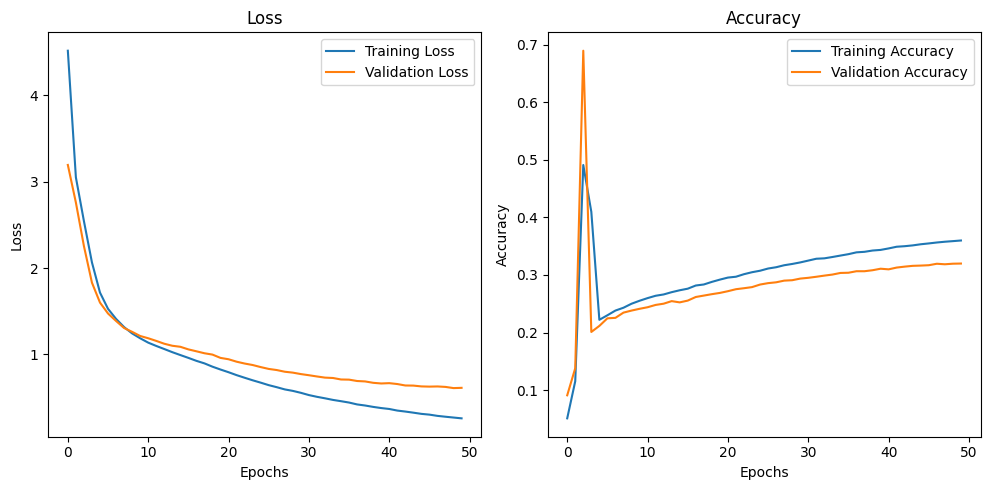

In [11]:
print("\nStep 4: Training the LSTM model...")

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
model_checkpoint = ModelCheckpoint(f'{lstm_dir}/lstm_model_best.h5', save_best_only=True, monitor='val_loss', verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001, verbose=1)

# Train the model
start_time = time.time()
history = model.fit(
    [X_train_padded, decoder_input_train],
    np.expand_dims(decoder_target_train, -1),
    validation_data=([X_val_padded, decoder_input_val], np.expand_dims(decoder_target_val, -1)),
    epochs=50,
    batch_size=64,
    callbacks=[early_stopping, model_checkpoint, reduce_lr],
    verbose=1
)
training_time = time.time() - start_time
print(f"Training completed in {training_time:.2f} seconds ({training_time/60:.2f} minutes)")

# Visualize training history
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot learning rate if available
if 'lr' in history.history:
    plt.subplot(1, 3, 3)
    plt.plot(history.history['lr'])
    plt.title('Learning Rate')
    plt.xlabel('Epochs')
    plt.ylabel('Learning Rate')

plt.tight_layout()
plt.savefig(f'{lstm_dir}/lstm_training_history.png')
plt.show()


In [12]:
print("\nStep 5: Creating inference model...")

# Create inference model
encoder_model = Model(encoder_inputs, [encoder_outputs] + encoder_states)

decoder_state_input_h = Input(shape=(lstm_units,))
decoder_state_input_c = Input(shape=(lstm_units,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_hidden_state_input = Input(shape=(max_input_len, lstm_units))

decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_embedding, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]

context_vector = attention([decoder_outputs, decoder_hidden_state_input])
decoder_combined_context = Concatenate()([decoder_outputs, context_vector])
decoder_outputs = decoder_dense(decoder_combined_context)

decoder_model = Model(
    [decoder_inputs, decoder_hidden_state_input] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

# Function for inference
def decode_sequence(input_seq):
    # Encode the input as state vectors
    encoder_outputs, state_h, state_c = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1 with only the start token
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = token_to_idx['<START>']

    # Output sequence
    decoded_tokens = []

    # Sampling loop
    stop_condition = False
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq, encoder_outputs, state_h, state_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = idx_to_token.get(sampled_token_index, '<UNK>')

        if sampled_token == '<END>' or len(decoded_tokens) > max_target_len-1:
            stop_condition = True
        else:
            decoded_tokens.append(sampled_token)

            # Update the target sequence
            target_seq = np.zeros((1, 1))
            target_seq[0, 0] = sampled_token_index

            # Update states
            state_h, state_c = h, c

    return decoded_tokens



Step 5: Creating inference model...


In [13]:
# Test on examples and visualize results
num_examples = 10
results = []

for i in tqdm(range(min(num_examples, len(test_df))), desc="Testing examples"):
    input_seq = X_test_padded[i:i+1]
    decoded_tokens = decode_sequence(input_seq)

    # Get original function and taylor expansion
    original_function = test_df['function'].iloc[i]
    original_taylor = test_df['taylor'].iloc[i]
    original_tokens = test_df['taylor_tokens'].iloc[i]

    results.append({
        'function': original_function,
        'actual_taylor': original_taylor,
        'predicted_tokens': decoded_tokens,
        'actual_tokens': original_tokens
    })

    print(f"\nExample {i+1}:")
    print(f"Function: {original_function}")
    print(f"Actual Taylor: {original_taylor}")
    print(f"Predicted Taylor tokens: {decoded_tokens}")

Testing examples:   0%|          | 0/10 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 631ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step

Example 1:
Function: (-0.21875*x**5 + 0.1875*x**4 - 0.875*x**3 + 0.5*x**2 + 2.5*x - 7)/(-1.0*x - 7)
Actual Taylor: -0.0446428571428571*x**4 + 0.125*x**3 - 6.93889390390723e-18*x**2 - 0.5*x + 1
Predicted Taylor tokens: ['-', 'NUM_405', '*

In [18]:
# Calculate accuracy metrics
token_accuracies = []
sequence_matches = 0

for result in results:
    # Check token-level accuracy
    min_len = min(len(result['actual_tokens']), len(result['predicted_tokens']))
    matches = sum(1 for i in range(min_len) if result['actual_tokens'][i] == result['predicted_tokens'][i])
    token_accuracy = matches / len(result['actual_tokens']) if result['actual_tokens'] else 0
    token_accuracies.append(token_accuracy)

    # Check exact sequence matches
    if result['actual_tokens'] == result['predicted_tokens']:
        sequence_matches += 1

avg_token_accuracy = np.mean(token_accuracies)
sequence_accuracy = sequence_matches / len(results)

print(f"\nAverage token-level accuracy: {avg_token_accuracy:.4f}")
print(f"Exact sequence match accuracy: {sequence_accuracy:.4f}")



Average token-level accuracy: 0.5471
Exact sequence match accuracy: 0.0000


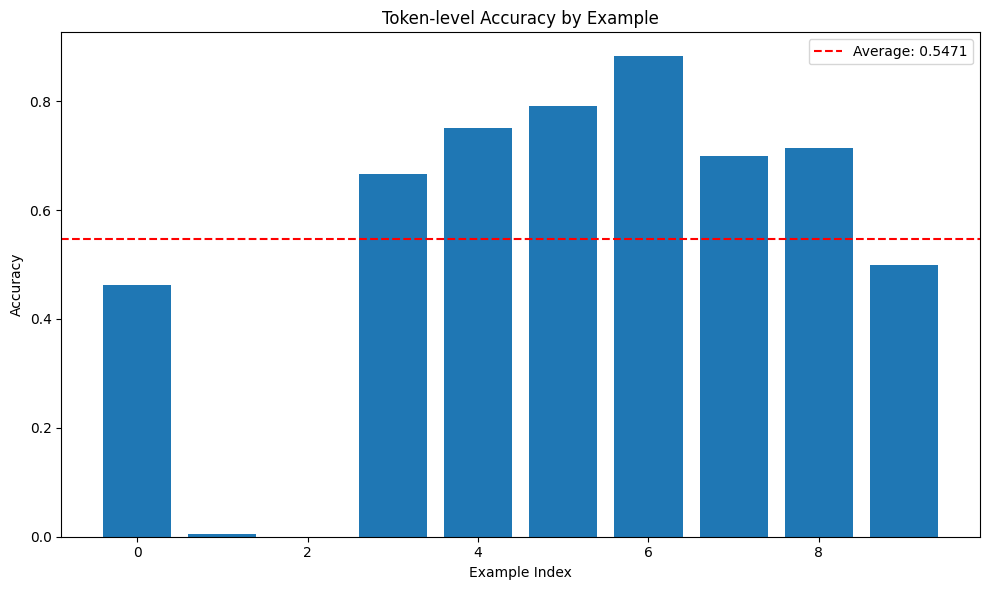

In [15]:
# Visualize prediction results
plt.figure(figsize=(10, 6))
plt.bar(range(len(token_accuracies)), token_accuracies)
plt.axhline(y=avg_token_accuracy, color='r', linestyle='--', label=f'Average: {avg_token_accuracy:.4f}')
plt.title('Token-level Accuracy by Example')
plt.xlabel('Example Index')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.savefig(f'{lstm_dir}/lstm_token_accuracy.png')
plt.show()

In [16]:
# Evaluate model on test set
print("\nStep 7: Evaluating model on test set...")
test_loss, test_acc = model.evaluate([X_test_padded, y_test_padded[:, :-1]],
                                     np.expand_dims(y_test_padded[:, 1:], -1),
                                     verbose=1)
print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")



Step 7: Evaluating model on test set...
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 284ms/step - accuracy: 0.3369 - loss: 0.6042

Test Loss: 0.6126
Test Accuracy: 0.3332


In [17]:
# Save model summary and metrics
with open(f'{lstm_dir}/lstm_model_summary.txt', 'w') as f:
    # Redirect summary to file
    model.summary(print_fn=lambda x: f.write(x + '\n'))

    f.write('\n\nModel Performance:\n')
    f.write(f"Test Loss: {test_loss:.4f}\n")
    f.write(f"Test Accuracy: {test_acc:.4f}\n")
    f.write(f"Average Token-level Accuracy: {avg_token_accuracy:.4f}\n")
    f.write(f"Exact Sequence Match Accuracy: {sequence_accuracy:.4f}\n")
    f.write(f"Training Time: {training_time:.2f} seconds ({training_time/60:.2f} minutes)\n")

print(f"\nLSTM model analysis complete and saved to {lstm_dir}/")


LSTM model analysis complete and saved to /content/drive/MyDrive/GSoC_Symbolic_Calculation/lstm_model/
